In [1]:
!source activate /home/gilbee3/anaconda3/envs/akita

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True) # Seaborn desaturates matplotlib colors (this is useful if you use both seaborn and basic matplot lib and want colors to be consistent)
import scipy.stats as stats
sns.set(palette='husl', context = 'talk', style='white')
import os
import scikit_posthocs as sp
from pybedtools import BedTool
from upsetplot import plot, from_indicators

In [3]:
BASE_PATH = "/".join(os.getcwd().split("/")) # base directory level

BIN_PATH = os.path.join(BASE_PATH, "bin")  # where my scripts live
DATA_PATH = os.path.join(BASE_PATH, "data")  # where I dump new data.
RESULTS_PATH = os.path.join(BASE_PATH, "results")  # where I analyze results

SRC_PATH = os.path.join(BASE_PATH, "src")  # where any packages needed to run analyses live. I haven't started structuring things this way yet. 

COMP_PATH = os.path.join(DATA_PATH,"pairwise/hsmrca")
#COMP_PATH = os.path.join(DATA_PATH,"pairwise/reference")

In [4]:

anc_spear = pd.read_table('/wynton/group/capra/projects/modern_human_3Dgenome/results/comp_tables/anc_window_spearman.csv'
                    , sep=',', header=[0,1,2,3], index_col=[0,1])
anc_div = 1-anc_spear
windows_to_keep = anc_div.index

# Genome Wide

In [5]:
def population_order(df, metric):
    sup_order = df.groupby(by=["super_pop"])[metric].mean().sort_values().index
    sub_order = df.groupby(by=["sub_pop"])[metric].mean().sort_values().index
    
    sup_mapping = pd.DataFrame({
    'super': sup_order,
    })
    sup_mapping = sup_mapping.reset_index().set_index('super')

    sub_mapping = pd.DataFrame({
        'sub': sub_order,
    })
    sub_mapping = sub_mapping.reset_index().set_index('sub')
    
    df['super_rank'] = df['super_pop'].map(sup_mapping['index'])
    df['sub_rank'] = df['sub_pop'].map(sub_mapping['index'])
    
    my_order = df.sort_values(['super_rank','sub_rank'])
    
    my_order = my_order['sub_pop'].drop_duplicates().values
    
    amr_pal = sns.diverging_palette(50,230, s=82, l=58, n=10)[-4:]
    eur_pal = sns.diverging_palette(50,230, s=82, l=58, n=15)[:5]
    afr_pal = sns.diverging_palette(50,369, s=82, l=58, n=17)[-7:]
    sas_pal = sns.diverging_palette(190,369, s=82, l=58, n=12)[:5]
    eas_pal = sns.diverging_palette(110,105, s=75, l=65, n=10)[:5]
    
    my_pal = eur_pal + amr_pal + eas_pal + sas_pal + afr_pal

    sub_order = my_order
    sub_pal = my_pal

    sup_pal = [eur_pal[0], amr_pal[3], eas_pal[0], sas_pal[0], afr_pal[6]]

    return sub_order, sub_pal, sup_order, sup_pal

In [6]:
def plot_pop_metric(df,my_order, my_pal, metric, ytitle):
    sns.set(font_scale=4, context = 'poster', style='white')
    plt.figure(figsize=(100,30))
    sns.stripplot(x='sub_pop', y=metric, data=df, dodge=False,s=20, 
                  palette=my_pal, 
                  order = my_order)
    plt.xlabel('\n1KG Population', fontsize=100)
    plt.ylabel(ytitle, fontsize=100)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=100)
    plt.tick_params(axis='both', which='major', labelsize=80)
    #plt.savefig('fig2.svg', format='svg')
    
    return

In [7]:
anc = pd.read_table('/wynton/group/capra/projects/modern_human_3Dgenome/results/comp_tables/anc_genomewide_averages.csv',
                    sep=',', index_col=0)
drops = anc[np.isnan(anc.genome_avg_mse)].index
anc = anc.drop(index=drops)
anc['divergence'] = 1-anc.genome_avg_spearman

In [8]:
sub_order, sub_pal, sup_order, sup_pal =population_order(anc, 'divergence')

In [9]:
sup_pal

[(0.706670293609049, 0.5093997303734449, 0.22414913576687667),
 (0.2541805512835154, 0.5821513974698465, 0.7274148776542794),
 (0.5061679352128585, 0.6675954483699535, 0.3024282922555064),
 (0.2416826875486161, 0.5991756083655165, 0.5923648937866773),
 (0.9420739404731048, 0.33350289719169146, 0.38668266469046336)]

No handles with labels found to put in legend.


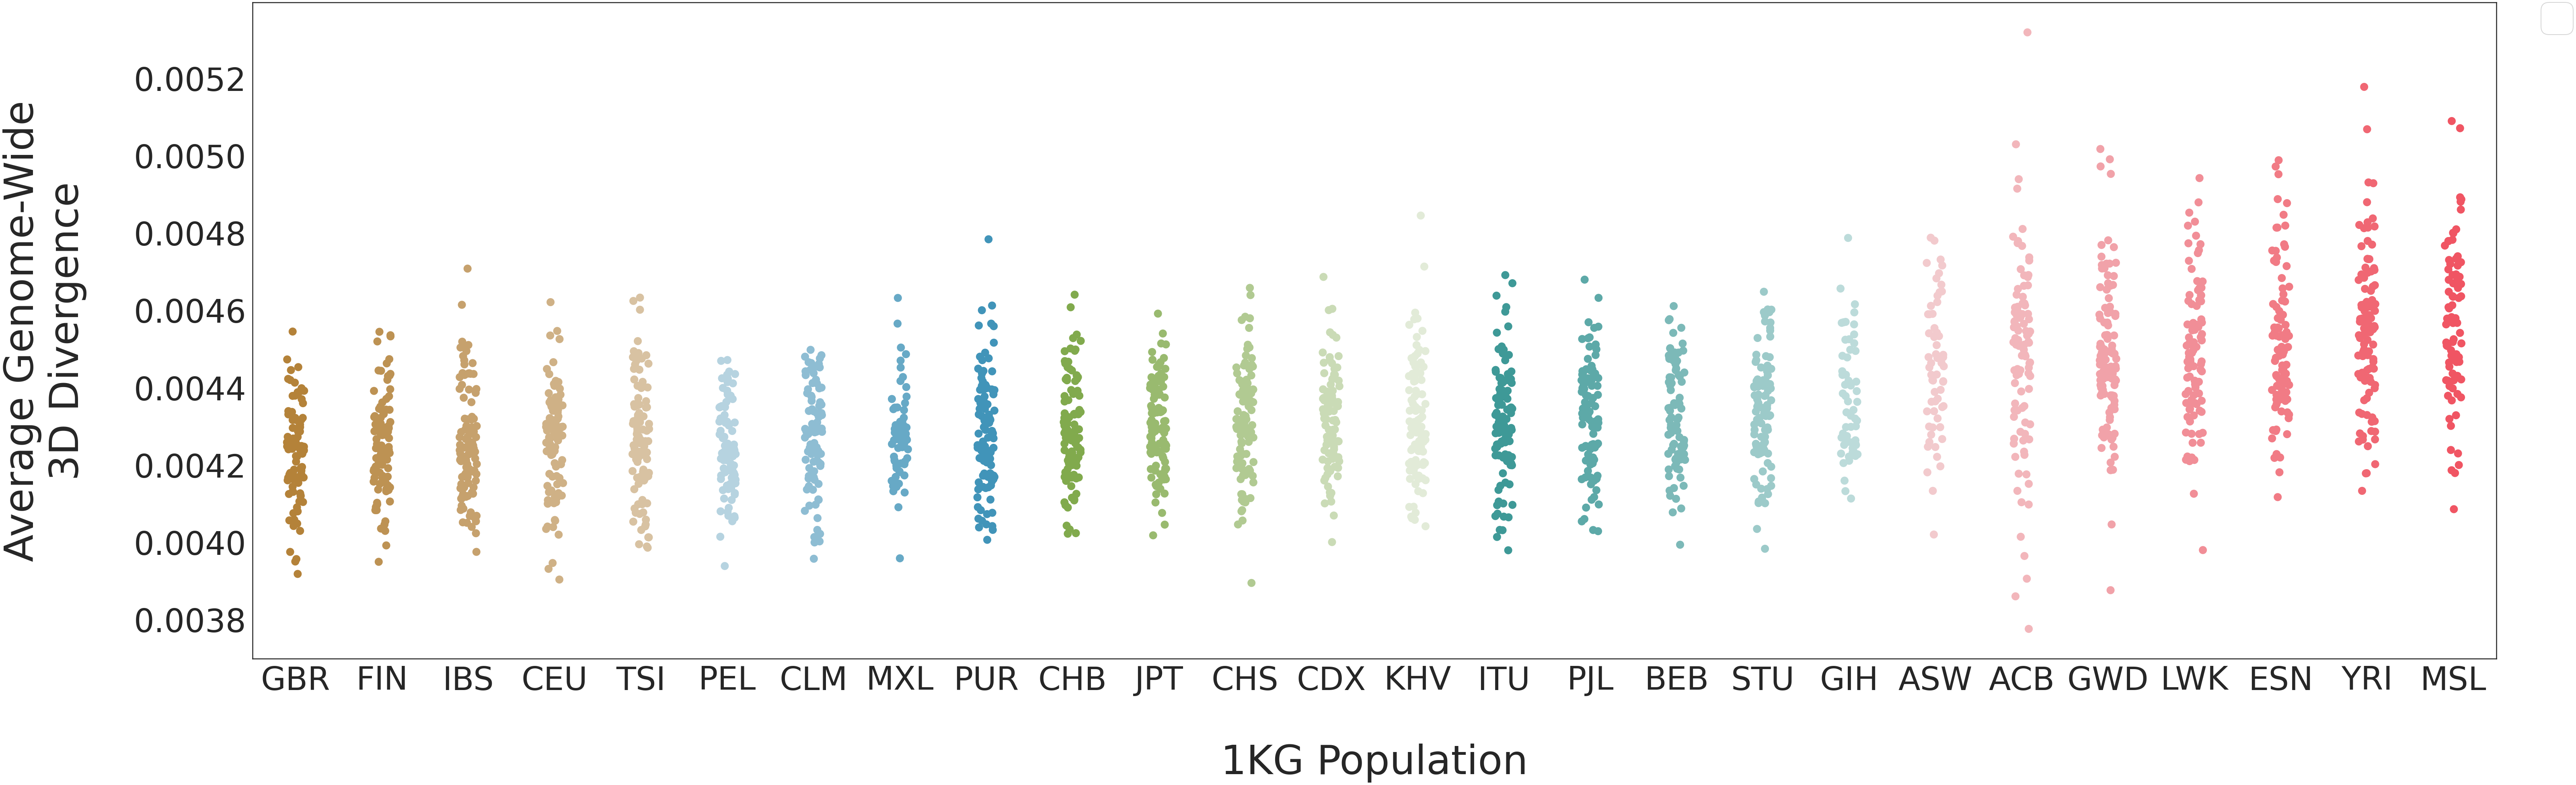

In [10]:
plot_pop_metric(anc, sub_order, sub_pal, 'divergence','Average Genome-Wide\n3D Divergence\n')

In [11]:
anc

,ancestor,genome_avg_mse,genome_avg_spearman,super_pop,sub_pop,sex,id,divergence,super_rank,sub_rank
1KG,,,,,,,,,,
AFR_ACB_female_HG01880,hsmrca_ancestral,0.000654,0.995720,AFR,ACB,female,HG01880,0.004280,4,20
AFR_ACB_female_HG01883,hsmrca_ancestral,0.000688,0.995387,AFR,ACB,female,HG01883,0.004613,4,20
AFR_ACB_female_HG01886,hsmrca_ancestral,0.000680,0.995517,AFR,ACB,female,HG01886,0.004483,4,20
AFR_ACB_female_HG01889,hsmrca_ancestral,0.000709,0.995272,AFR,ACB,female,HG01889,0.004728,4,20
AFR_ACB_female_HG01894,hsmrca_ancestral,0.000683,0.995589,AFR,ACB,female,HG01894,0.004411,4,20
...,...,...,...,...,...,...,...,...,...,...
SAS_STU_male_HG04039,hsmrca_ancestral,0.000642,0.995748,SAS,STU,male,HG04039,0.004252,3,17
SAS_STU_male_HG04100,hsmrca_ancestral,0.000664,0.995672,SAS,STU,male,HG04100,0.004328,3,17
SAS_STU_male_HG04107,hsmrca_ancestral,0.000671,0.995665,SAS,STU,male,HG04107,0.004335,3,17


In [12]:
anc[anc['sub_pop']=='PUR'].divergence.idxmax()

'AMR_PUR_female_HG01108'

## Sequence

### Import Sequence Data

In [13]:
list_file = os.path.join(DATA_PATH, "reference/lists/listOfPairwiseComps_hsmrca.txt")
base = 'hsmrca_ancestral'
COMP_PATH = os.path.join(DATA_PATH,"pairwise/sequence/1KGvsHSMRCA")

base_df = anc[['ancestor']]
comp_dict_seq = {}
print('first for')
for row in base_df.index:
    ind = str(base_df.loc[row].name)
    filename = 'SeqComps_%s_vs_%s.txt' % (ind,base)
    if os.path.exists('%s/%s' % (COMP_PATH,filename)):
        try:
            df = pd.read_table('%s/%s' % (COMP_PATH,filename))
            df = df[df.chrm != 'chrX']
            comp_dict_seq[ind] = df
        except:
            print('broken')
            continue     
print('done')

indivs = list(comp_dict_seq.keys())
### Window by window
seq_id = pd.DataFrame(index = windows_to_keep, columns = indivs)

### Genome wide averages        
base_df['seq_id']=''
print('second for')
for ind in comp_dict_seq.keys():
    df = comp_dict_seq[ind]
    df = df.set_index(['chrm','start_loc'])
    try:
        df = df.loc[windows_to_keep]
        avg_seq_id =float(np.mean(df['seqComp_raw'].astype('float')))

        base_df.seq_id.loc[ind]=avg_seq_id

        seq_id[ind]=df['seqComp_raw'].astype(float)
    except:
        print('missing data for individual: %s' % ind)
print('done')  



base_df['temp'] = base_df.index
new = base_df.temp.str.split("_", expand = True)
base_df['super_pop'] = new[0]
base_df['sub_pop'] = new[1]
base_df['sex'] = new[2]
base_df['id'] = new[3]

genome_wide = base_df.drop(columns=['temp'])
genome_wide = genome_wide[genome_wide.seq_id != '']
genome_wide.seq_id = genome_wide.seq_id.astype('float')

seq_id.columns = seq_id.columns.str.split('_', expand=True)

first for
done


/wynton/home/capra/egilbertson/envs/akita/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/wynton/home/capra/egilbertson/envs/akita/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


second for
missing data for individual: SAS_ITU_male_HG04060
done


/wynton/home/capra/egilbertson/envs/akita/lib/python3.6/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/wynton/home/capra/egilbertson/envs/akita/lib/python3.6/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/wynton/home/capra/egilbertson/envs/akita/lib/python3.6/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [14]:
genome_wide['seq_diff'] = 1-genome_wide['seq_id']

## Correlate Sequence and 3D

In [15]:
anc

,ancestor,genome_avg_mse,genome_avg_spearman,super_pop,sub_pop,sex,id,divergence,super_rank,sub_rank
1KG,,,,,,,,,,
AFR_ACB_female_HG01880,hsmrca_ancestral,0.000654,0.995720,AFR,ACB,female,HG01880,0.004280,4,20
AFR_ACB_female_HG01883,hsmrca_ancestral,0.000688,0.995387,AFR,ACB,female,HG01883,0.004613,4,20
AFR_ACB_female_HG01886,hsmrca_ancestral,0.000680,0.995517,AFR,ACB,female,HG01886,0.004483,4,20
AFR_ACB_female_HG01889,hsmrca_ancestral,0.000709,0.995272,AFR,ACB,female,HG01889,0.004728,4,20
AFR_ACB_female_HG01894,hsmrca_ancestral,0.000683,0.995589,AFR,ACB,female,HG01894,0.004411,4,20
...,...,...,...,...,...,...,...,...,...,...
SAS_STU_male_HG04039,hsmrca_ancestral,0.000642,0.995748,SAS,STU,male,HG04039,0.004252,3,17
SAS_STU_male_HG04100,hsmrca_ancestral,0.000664,0.995672,SAS,STU,male,HG04100,0.004328,3,17
SAS_STU_male_HG04107,hsmrca_ancestral,0.000671,0.995665,SAS,STU,male,HG04107,0.004335,3,17


In [16]:
genome_wide_both = genome_wide.merge(anc[['divergence', 'super_rank','sub_rank']], how='inner', left_index=True, right_index=True).drop(columns=['seq_id'])

In [17]:
sns.set(palette='husl', context = 'talk', style='white')

In [18]:
sup_pal

[(0.706670293609049, 0.5093997303734449, 0.22414913576687667),
 (0.2541805512835154, 0.5821513974698465, 0.7274148776542794),
 (0.5061679352128585, 0.6675954483699535, 0.3024282922555064),
 (0.2416826875486161, 0.5991756083655165, 0.5923648937866773),
 (0.9420739404731048, 0.33350289719169146, 0.38668266469046336)]

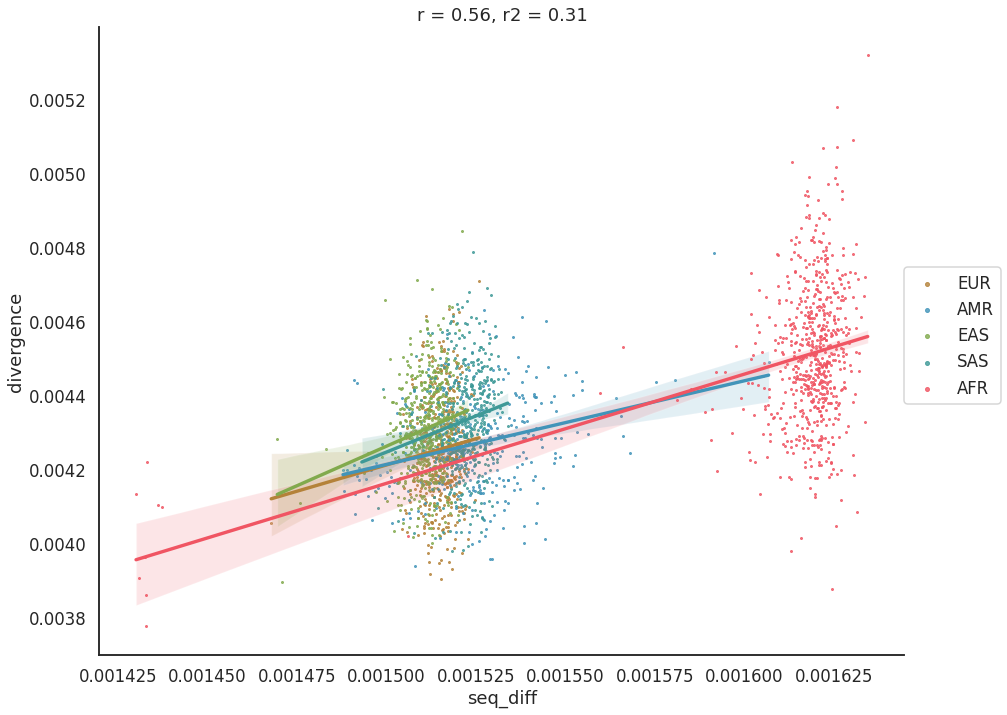

In [19]:
sns.lmplot(x='seq_diff',y='divergence', hue='super_pop', data=genome_wide_both,scatter_kws={'s':4},aspect=1.3,palette = sup_pal,  
hue_order = sup_order, legend=False, height=10)

slope, intercept, r, p, se = stats.linregress(genome_wide_both['seq_diff'].values, genome_wide_both['divergence'].values)
plt.title('r = %0.2f, r2 = %0.2f' % (r, r**2))
plt.legend(markerscale=2, loc=(1,.4))


## Plot

No handles with labels found to put in legend.


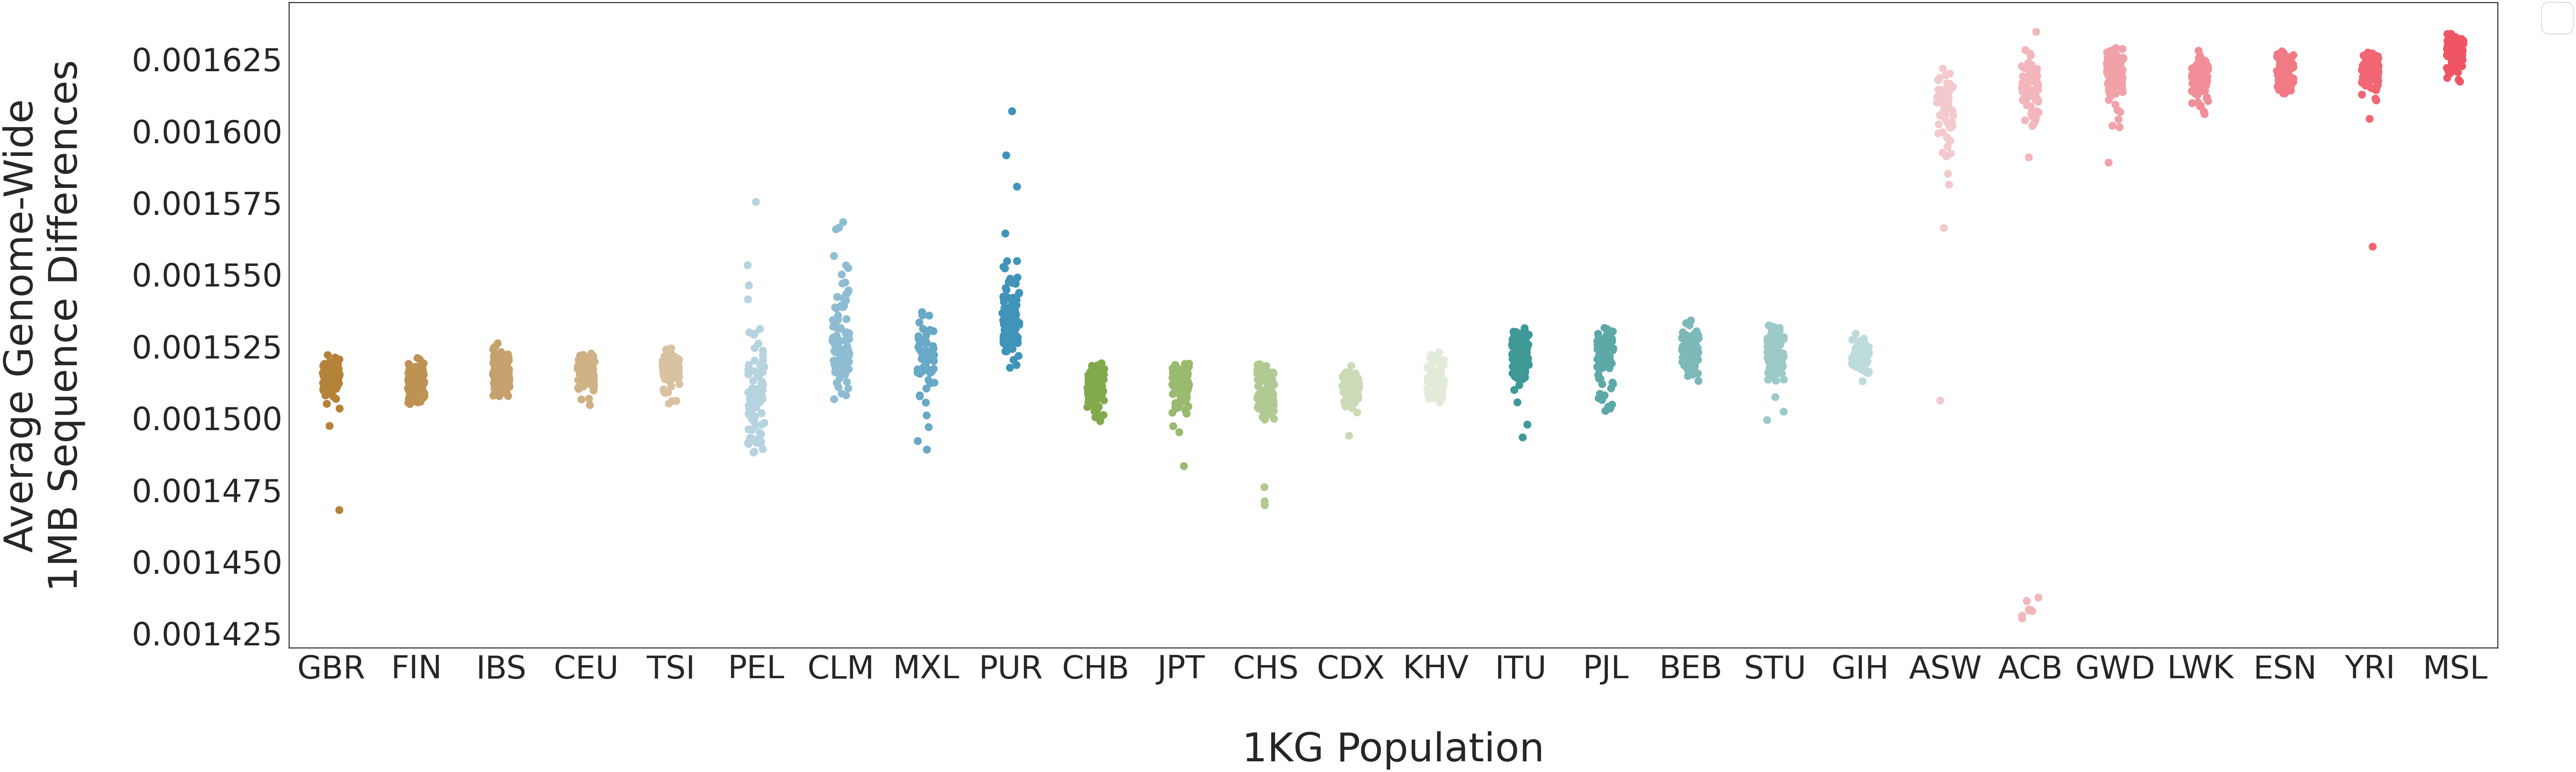

In [20]:
plot_pop_metric(genome_wide, sub_order, sub_pal, 'seq_diff','Average Genome-Wide\n1MB Sequence Differences\n')

# Windows

In [21]:
sns.set(palette='husl', font_scale=1, context = 'poster', style='white')

Text(0.5, 0, 'Chromosome 20 Position')

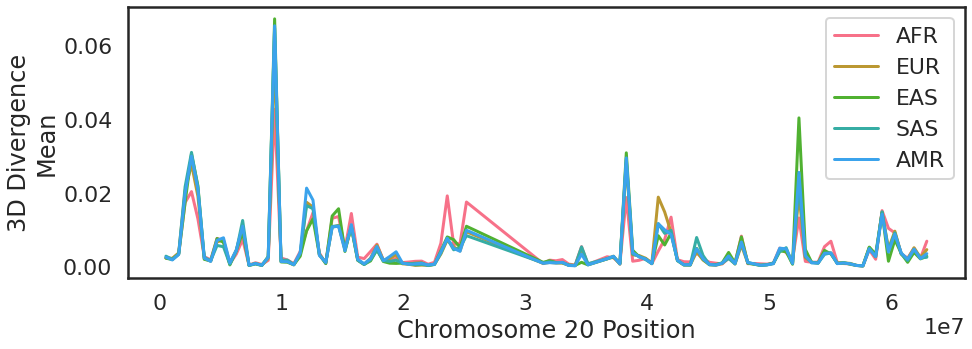

In [22]:
df = anc_div
chrm='chr20'

afr_avg = df['AFR'].mean(axis=1)
amr_avg = df['AMR'].mean(axis=1)
eur_avg = df['EUR'].mean(axis=1)
eas_avg = df['EAS'].mean(axis=1)
sas_avg = df['SAS'].mean(axis=1)

windows = pd.DataFrame([afr_avg, amr_avg, eur_avg, eas_avg, sas_avg]).transpose()
windows.columns = ['AFR','AMR','EUR','EAS','SAS']

windows['AVERAGE'] = windows.mean(axis=1)

df = windows.loc[chrm]

fig, ax = plt.subplots(figsize=[15,5])
sns.lineplot(y=df.AFR, 
             x=df.index, 
            label='AFR')
sns.lineplot(y=df.EUR, 
             x=df.index, 
            label='EUR')
sns.lineplot(y=df.EAS, 
             x=df.index, 
            label='EAS')
sns.lineplot(y=df.SAS, 
             x=df.index, 
            label='SAS')
sns.lineplot(y=df.AMR, 
             x=df.index, 
            label='AMR')



plt.ylabel('3D Divergence\nMean')
plt.xlabel('Chromosome 20 Position')

Text(0.5, 0, 'Chromosome 20 Position')

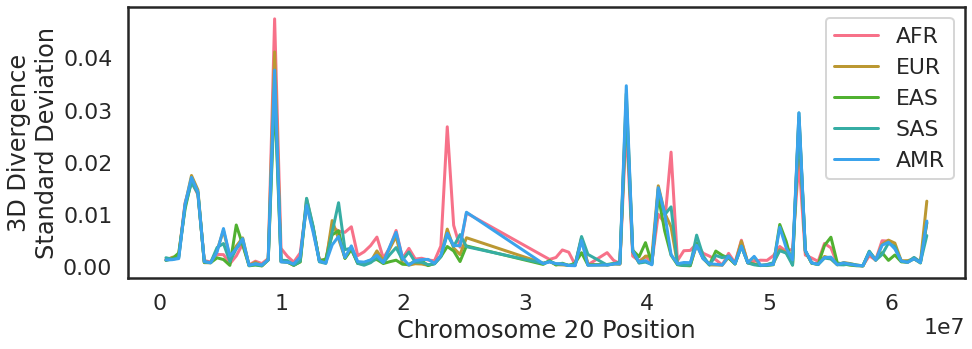

In [23]:
df = anc_div
chrm='chr20'

afr_avg = df['AFR'].std(axis=1)
amr_avg = df['AMR'].std(axis=1)
eur_avg = df['EUR'].std(axis=1)
eas_avg = df['EAS'].std(axis=1)
sas_avg = df['SAS'].std(axis=1)

windows = pd.DataFrame([afr_avg, amr_avg, eur_avg, eas_avg, sas_avg]).transpose()
windows.columns = ['AFR','AMR','EUR','EAS','SAS']

windows['AVERAGE'] = windows.mean(axis=1)

df = windows.loc[chrm]

fig, ax = plt.subplots(figsize=[15,5])
sns.lineplot(y=df.AFR, 
             x=df.index, 
            label='AFR')
sns.lineplot(y=df.EUR, 
             x=df.index, 
            label='EUR')
sns.lineplot(y=df.EAS, 
             x=df.index, 
            label='EAS')
sns.lineplot(y=df.SAS, 
             x=df.index, 
            label='SAS')
sns.lineplot(y=df.AMR, 
             x=df.index, 
            label='AMR')



plt.ylabel('3D Divergence\nStandard Deviation')
plt.xlabel('Chromosome 20 Position')


In [24]:
anc_div['AMR','PUR','female','HG01108'].idxmax()

('chr9', 22544384)

In [25]:
anc_div.loc['chr1',1048576]['AMR','PUR','female','HG01108']

0.0015560369301823584

In [26]:
afr_std =anc_div['AFR'].std(axis=1)
amr_std =anc_div['AMR'].std(axis=1)
eur_std =anc_div['EUR'].std(axis=1)
eas_std =anc_div['EAS'].std(axis=1)
sas_std =anc_div['SAS'].std(axis=1)

afr_avg =anc_div['AFR'].mean(axis=1)
amr_avg =anc_div['AMR'].mean(axis=1)
eur_avg =anc_div['EUR'].mean(axis=1)
eas_avg =anc_div['EAS'].mean(axis=1)
sas_avg =anc_div['SAS'].mean(axis=1)

windows_by_pop = pd.DataFrame([afr_avg, amr_avg, eur_avg, eas_avg, sas_avg, afr_std, amr_std, eur_std, eas_std, sas_std]).transpose()
windows_by_pop.columns = ['AFR_mean','AMR_mean','EUR_mean','EAS_mean','SAS_mean', 'AFR_std','AMR_std','EUR_std','EAS_std','SAS_std']

windows_by_pop['ALL_mean'] = anc_div.mean(axis=1)
windows_by_pop['ALL_std'] = anc_div.std(axis=1)


In [27]:
windows_by_pop

AFR_mean  AMR_mean  EUR_mean  EAS_mean  SAS_mean  \
chr   windowStartPos                                                     
chr1  1048576         0.001596  0.000881  0.000648  0.001091  0.000889   
      1572864         0.002087  0.001167  0.001148  0.001519  0.001216   
      3145728         0.002669  0.003333  0.002607  0.004419  0.002747   
      3670016         0.004773  0.004380  0.004600  0.004405  0.004836   
      4194304         0.009120  0.008632  0.009555  0.007170  0.008487   
...                        ...       ...       ...       ...       ...   
chr22 46661632        0.004763  0.003424  0.003324  0.003265  0.002981   
      47185920        0.011735  0.005060  0.004423  0.006339  0.006914   
      47710208        0.055222  0.059584  0.060998  0.053654  0.047924   
      48234496        0.204803  0.219469  0.214279  0.197077  0.187636   
      48758784        0.008367  0.005016  0.004276  0.004971  0.005018   

                       AFR_std   AMR_std   EUR_std   EAS_std   SAS_std  \
chr   windowStartPos                                                     
chr1  1048576         0.000834  0.000565  0.000449  0.002823  0.000436   
      1572864         0.001091  0.000576  0.000514  0.003997  0.000899   
      3145728         0.002707  0.002587  0.002303  0.002527  0.002268   
      3670016         0.001677  0.001306  0.004735  0.001116  0.001610   
      4194304         0.002968  0.003223  0.009507  0.002685  0.003270   
...                        ...       ...       ...       ...       ...   
chr22 46661632        0.002922  0.001475  0.004090  0.001231  0.001646   
      47185920        0.011732  0.003434  0.002042  0.003512  0.020782   
      47710208        0.024968  0.026555  0.028428  0.028623  0.022950   
      48234496        0.058776  0.064189  0.073819  0.066296  0.056998   
      48758784        0.003559  0.002211  0.001532  0.001635  0.001988   

                      ALL_mean   ALL_std  
chr   windowStartPos                      
chr1  1048576         0.001070  0.001436  
      1572864         0.001491  0.001996  
      3145728         0.003123  0.002591  
      3670016         0.004618  0.002516  
      4194304         0.008626  0.005136  
...                        ...       ...  
chr22 46661632        0.003650  0.002700  
      47185920        0.007318  0.011298  
      47710208        0.055384  0.026721  
      48234496        0.204137  0.064962  
      48758784        0.005755  0.002899  

[4873 rows x 12 columns]

## Overlap Genes with top 10% of windows

In [28]:
top_10 = windows_by_pop[windows_by_pop.ALL_mean >= (windows_by_pop.ALL_mean.quantile(.9))].index

In [29]:
top_10 = top_10.to_frame(index=False)

In [30]:
lower_90 = windows_by_pop[windows_by_pop.ALL_mean < (windows_by_pop.ALL_mean.quantile(.9))].index
lower_90 = lower_90.to_frame(index=False)

In [31]:
genes = pybedtools.BedTool('/wynton/group/capra/projects/modern_human_3Dgenome/data/phenotype_enrichment_divergent_from_ancestral/data/grch38_gene_annotations.bed')

NameError: name 'pybedtools' is not defined

In [ ]:
all_windows = pd.DataFrame(index=windows_by_pop.index).reset_index()
all_windows.columns = ['chr','start']


In [ ]:
all_windows['end'] = all_windows['start'] + 2**20
top_10['end'] = top_10['windowStartPos'] + 2**20
lower_90['end'] = lower_90['windowStartPos'] + 2**20

In [ ]:
all_bed = pybedtools.BedTool.from_dataframe(all_windows)
top_bed = pybedtools.BedTool.from_dataframe(top_10)
lower_bed = pybedtools.BedTool.from_dataframe(lower_90)

In [ ]:
gene_overlap_top = top_bed.intersect(genes, wao=True).to_dataframe(names=['window_chrm','start','end','gene_chr','gene_start','gene_end','gene_name','overlap'])
gene_overlap_all = all_bed.intersect(genes, wao=True).to_dataframe(names=['window_chrm','start','end','gene_chr','gene_start','gene_end','gene_name','overlap'])
gene_overlap_lower = lower_bed.intersect(genes, wao=True).to_dataframe(names=['window_chrm','start','end','gene_chr','gene_start','gene_end','gene_name','overlap'])

In [ ]:
gene_overlap_all

,window_chrm,start,end,gene_chr,gene_start,gene_end,gene_name,overlap
0,chr1,1048576,2097152,chr1,1070965,1074307,RNF223,3342
1,chr1,1048576,2097152,chr1,1203507,1206571,TNFRSF18,3064
2,chr1,1048576,2097152,chr1,1232264,1235041,B3GALT6,2777
3,chr1,1048576,2097152,chr1,1280435,1292019,SCNN1D,11584
4,chr1,1048576,2097152,chr1,1311596,1324691,CPSF3L,13095
...,...,...,...,...,...,...,...,...
36897,chr22,46661632,47710208,chr22,46762620,47175693,TBC1D22A,413073
36898,chr22,47185920,48234496,.,-1,-1,.,0
36899,chr22,47710208,48758784,chr22,48576305,48751932,FAM19A5,175627
36900,chr22,48234496,49283072,chr22,48576305,48751932,FAM19A5,175627


In [ ]:
gene_overlap_lower

,window_chrm,start,end,gene_chr,gene_start,gene_end,gene_name,overlap
0,chr1,1048576,2097152,chr1,1070965,1074307,RNF223,3342
1,chr1,1048576,2097152,chr1,1203507,1206571,TNFRSF18,3064
2,chr1,1048576,2097152,chr1,1232264,1235041,B3GALT6,2777
3,chr1,1048576,2097152,chr1,1280435,1292019,SCNN1D,11584
4,chr1,1048576,2097152,chr1,1311596,1324691,CPSF3L,13095
...,...,...,...,...,...,...,...,...
34352,chr22,46661632,47710208,chr22,46684410,46738261,CERK,53851
34353,chr22,46661632,47710208,chr22,46620401,46679785,GRAMD4,18153
34354,chr22,46661632,47710208,chr22,46762620,47175693,TBC1D22A,413073
34355,chr22,47185920,48234496,.,-1,-1,.,0


In [ ]:
gene_overlap_top

,window_chrm,start,end,gene_chr,gene_start,gene_end,gene_name,overlap
0,chr1,41418752,42467328,chr1,42153420,42155824,GUCA2B,2404
1,chr1,41418752,42467328,chr1,42162690,42164718,GUCA2A,2028
2,chr1,41418752,42467328,chr1,42456558,42460414,PPCS,3856
3,chr1,41418752,42467328,chr1,41478774,41484671,EDN2,5897
4,chr1,41418752,42467328,chr1,42380805,42422578,RIMKLA,41773
...,...,...,...,...,...,...,...,...
2540,chr22,44564480,45613056,chr22,44881161,45009700,PHF21B,128539
2541,chr22,44564480,45613056,chr22,45190337,45240769,KIAA0930,50432
2542,chr22,44564480,45613056,chr22,45344062,45413567,SMC1B,69505
2543,chr22,47710208,48758784,chr22,48576305,48751932,FAM19A5,175627


In [ ]:
2556/36902

0.06926453850739797

In [ ]:
34346/36902

0.930735461492602

In [ ]:
(2556/36902) + (34346/36902)

1.0

## Shared top windows between populations

In [ ]:
def check_top_percentile(windows_by_pop, percentile, metric):
    for pop in ['AFR','AMR','EUR','EAS','SAS']:
        windows_by_pop['%s_top'%pop] = windows_by_pop['%s_%s'%(pop, metric)]>= (windows_by_pop['%s_%s'%(pop, metric)].quantile(percentile))
    return windows_by_pop

In [ ]:
windows_by_pop = check_top_percentile(windows_by_pop, 0.9, 'mean')

In [ ]:
windows_by_pop

AFR_mean  AMR_mean  EUR_mean  EAS_mean  SAS_mean  \
chr   windowStartPos                                                     
chr1  1048576         0.001596  0.000881  0.000648  0.001091  0.000889   
      1572864         0.002087  0.001167  0.001148  0.001519  0.001216   
      3145728         0.002669  0.003333  0.002607  0.004419  0.002747   
      3670016         0.004773  0.004380  0.004600  0.004405  0.004836   
      4194304         0.009120  0.008632  0.009555  0.007170  0.008487   
...                        ...       ...       ...       ...       ...   
chr22 46661632        0.004763  0.003424  0.003324  0.003265  0.002981   
      47185920        0.011735  0.005060  0.004423  0.006339  0.006914   
      47710208        0.055222  0.059584  0.060998  0.053654  0.047924   
      48234496        0.204803  0.219469  0.214279  0.197077  0.187636   
      48758784        0.008367  0.005016  0.004276  0.004971  0.005018   

                       AFR_std   AMR_std   EUR_std   EAS_std   SAS_std  \
chr   windowStartPos                                                     
chr1  1048576         0.000834  0.000565  0.000449  0.002823  0.000436   
      1572864         0.001091  0.000576  0.000514  0.003997  0.000899   
      3145728         0.002707  0.002587  0.002303  0.002527  0.002268   
      3670016         0.001677  0.001306  0.004735  0.001116  0.001610   
      4194304         0.002968  0.003223  0.009507  0.002685  0.003270   
...                        ...       ...       ...       ...       ...   
chr22 46661632        0.002922  0.001475  0.004090  0.001231  0.001646   
      47185920        0.011732  0.003434  0.002042  0.003512  0.020782   
      47710208        0.024968  0.026555  0.028428  0.028623  0.022950   
      48234496        0.058776  0.064189  0.073819  0.066296  0.056998   
      48758784        0.003559  0.002211  0.001532  0.001635  0.001988   

                      ALL_mean   ALL_std  AFR_top  AMR_top  EUR_top  EAS_top  \
chr   windowStartPos                                                           
chr1  1048576         0.001070  0.001436    False    False    False    False   
      1572864         0.001491  0.001996    False    False    False    False   
      3145728         0.003123  0.002591    False    False    False    False   
      3670016         0.004618  0.002516    False    False    False    False   
      4194304         0.008626  0.005136    False    False     True    False   
...                        ...       ...      ...      ...      ...      ...   
chr22 46661632        0.003650  0.002700    False    False    False    False   
      47185920        0.007318  0.011298     True    False    False    False   
      47710208        0.055384  0.026721     True     True     True     True   
      48234496        0.204137  0.064962     True     True     True     True   
      48758784        0.005755  0.002899    False    False    False    False   

                      SAS_top  
chr   windowStartPos           
chr1  1048576           False  
      1572864           False  
      3145728           False  
      3670016           False  
      4194304           False  
...                       ...  
chr22 46661632          False  
      47185920          False  
      47710208           True  
      48234496           True  
      48758784          False  

[4873 rows x 17 columns]

In [ ]:
top_windows_by_pop = windows_by_pop[['AFR_top','AMR_top','EUR_top','EAS_top','SAS_top']]
top_windows_by_pop = top_windows_by_pop[(top_windows_by_pop ==True).any(axis=1)]

In [ ]:
def upset(pops_out):
    indicators = pops_out.reset_index().drop(columns=['chr','windowStartPos'])
    listy = pops_out.index
    listx=[]
    for i in listy:
        listx.append(str(i))
    data = pd.DataFrame({"value": listx, **indicators})
    ind_dict = {}
    for pop in indicators.columns:
        ind_dict[pop] = list(indicators[pop].values)
    e = from_indicators(ind_dict, data = data)
    fig= plt.figure(figsize=(30,10))
    plot(e, fig=fig, element_size=None, sort_by='cardinality', show_counts=True)
    return

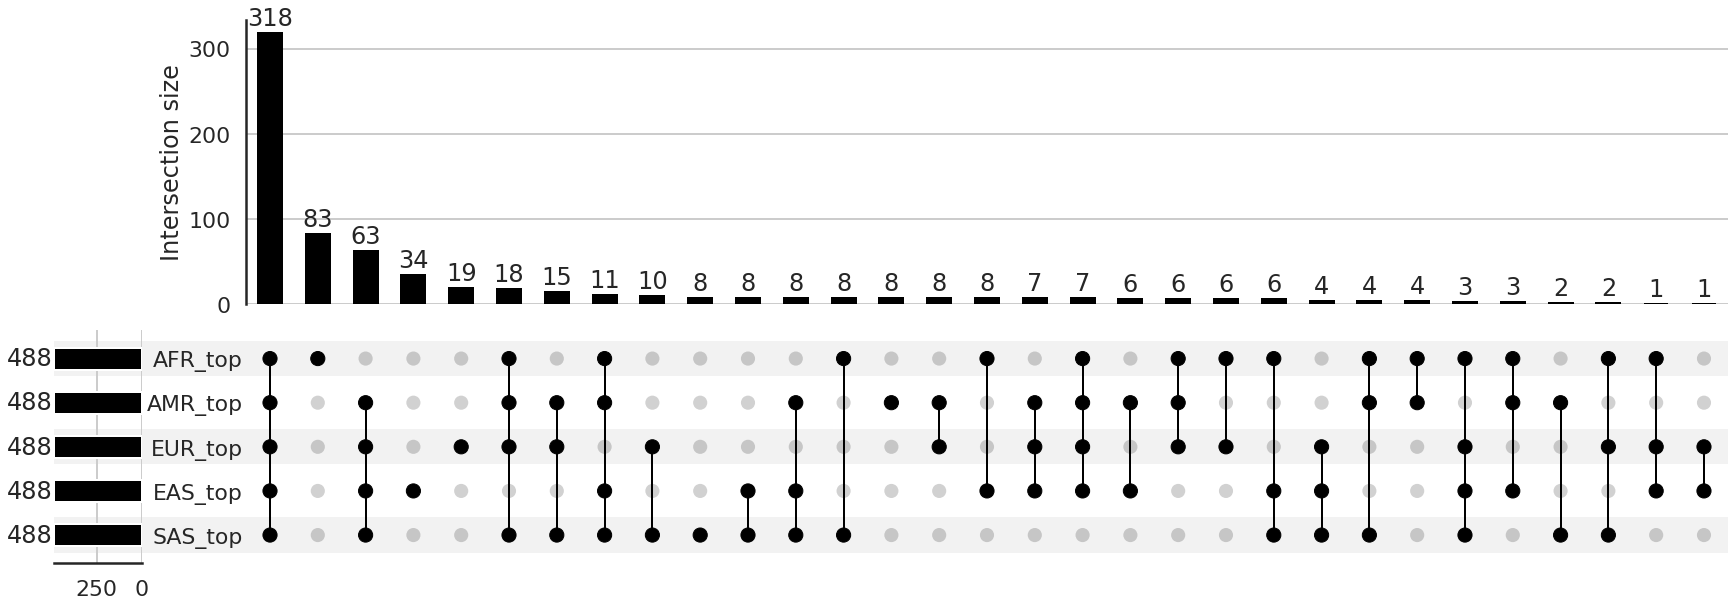

In [ ]:
upset(top_windows_by_pop)

In [ ]:
318+69+59+32+19+18+14+11+9+9+8+8+(7*3)+(6*3)+(5*3)+(4*3)+(3*8)+(2*8)+(1*9)

689

In [ ]:
top_windows_by_pop.shape

(689, 5)

In [ ]:
top_windows_by_pop

AFR_top  AMR_top  EUR_top  EAS_top  SAS_top
chr   windowStartPos                                             
chr1  4194304           False    False     True    False    False
      31457280           True    False    False    False    False
      41418752           True    False     True     True     True
      57147392          False     True     True     True     True
      57671680          False     True    False    False    False
...                       ...      ...      ...      ...      ...
chr22 34078720           True     True    False    False     True
      44564480          False     True     True     True     True
      47185920           True    False    False    False    False
      47710208           True     True     True     True     True
      48234496           True     True     True     True     True

[689 rows x 5 columns]

In [ ]:
def PercentileToQuartile(x):
    if x < 0.25:
        return 1
    elif x < 0.5:
        return 2
    elif x < 0.75:
        return 3
    else:
        return 4

/wynton/home/capra/egilbertson/envs/akita/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
def QuantAnnotate_genes(windows_by_pop, genes):
    regions = windows_by_pop[['ALL_mean','ALL_std']]
    regions['divergence_percentile'] = percentiles_allpops['ALL_mean'].rank(pct=True)
    regions = percentiles_allpops.reset_index()
    regions['divergence_percentile_group'] = regions['divergence_percentile'].apply(PercentileToQuartile)
    regions['stop'] = regions['windowStartPos'] + 2**20

    regions = regions[['chr','windowStartPos','stop','ALL_mean','ALL_std','divergence_percentile','divergence_percentile_group']]
    regions.columns = ['chr','start','stop'] + list(regions.columns)[3:]
    region_list = regions[['chr','start','stop', 'divergence_percentile_group']]

    annotation = BedTool.from_dataframe(regions).intersect(genes, wo=True).to_dataframe(disable_auto_names=True, header=None)
    annotation.columns = list(regions.columns) + ['elem_chr','elem_start','elem_stop','gene_name','numBases']
    annotation['annot_count'] = 1
    annotation = region_list.merge(annotation, on=['chr','start','stop', 'divergence_percentile_group'], how='outer')

    annotation_grouped = annotation.groupby(['chr', 'start','stop']).agg({'numBases': 'sum','annot_count':'sum', 'divergence_percentile_group':'mean'})
    annotation_grouped['propBasesCovered'] = annotation_grouped['numBases']/(2**20)

    annotation_grouped= annotation_grouped.reset_index()

    return annotation_grouped

In [ ]:
annotation = QuantAnnotate_genes(windows_by_pop, genes)

/wynton/home/capra/egilbertson/envs/akita/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


r2 =  0.013758754841103555 p = 2.1312714112739878e-16


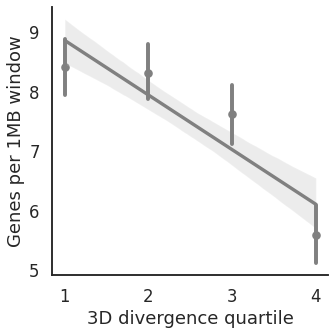

In [ ]:
g = sns.lmplot(x='divergence_percentile_group', y='annot_count', data=annotation, x_estimator=np.mean, line_kws={'color': 'grey'}, scatter_kws={'color': 'grey'})
g.set(xticks=[1,2,3,4],xlabel="3D divergence quartile", ylabel="Genes per 1MB window")

slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['divergence_percentile_group'],annotation['annot_count'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))

In [ ]:
def QuantAnnotate_ctcf(windows_by_pop, genes):
    regions = windows_by_pop[['ALL_mean','ALL_std']]
    regions['divergence_percentile'] = percentiles_allpops['ALL_mean'].rank(pct=True)
    regions = percentiles_allpops.reset_index()
    regions['divergence_percentile_group'] = regions['divergence_percentile'].apply(PercentileToQuartile)
    regions['stop'] = regions['windowStartPos'] + 2**20

    regions = regions[['chr','windowStartPos','stop','ALL_mean','ALL_std','divergence_percentile','divergence_percentile_group']]
    regions.columns = ['chr','start','stop'] + list(regions.columns)[3:]
    region_list = regions[['chr','start','stop', 'divergence_percentile_group']]

    annotation = BedTool.from_dataframe(regions).intersect(genes, wo=True).to_dataframe(disable_auto_names=True, header=None)
    annotation.columns = list(regions.columns) + ['elem_chr','elem_start','elem_stop','numBases']
    annotation['annot_count'] = 1
    annotation = region_list.merge(annotation, on=['chr','start','stop', 'divergence_percentile_group'], how='outer')

    annotation_grouped = annotation.groupby(['chr', 'start','stop']).agg({'numBases': 'sum','annot_count':'sum', 'divergence_percentile_group':'mean'})
    annotation_grouped['propBasesCovered'] = annotation_grouped['numBases']/(2**20)

    annotation_grouped= annotation_grouped.reset_index()

    return annotation_grouped

In [ ]:
ctcf = pybedtools.BedTool('/wynton/group/capra/projects/modern_human_3Dgenome/data/annotations/ctcf_full_merged.bed')
annotation = QuantAnnotate_ctcf(windows_by_pop, ctcf)

/wynton/home/capra/egilbertson/envs/akita/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


r2 =  0.024779073498400892 p = 2.0797551122560453e-28


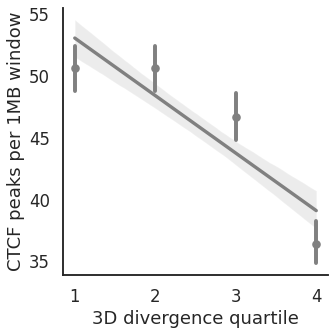

In [ ]:
g = sns.lmplot(x='divergence_percentile_group', y='annot_count', data=annotation, x_estimator=np.mean, line_kws={'color': 'grey'}, scatter_kws={'color': 'grey'})
g.set(xticks=[1,2,3,4],xlabel="3D divergence quartile", ylabel="CTCF peaks per 1MB window")

slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['divergence_percentile_group'],annotation['annot_count'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))

In [ ]:
def conservationQuantification(regions, propBases=False):
    regions = windows_by_pop[['ALL_mean','ALL_std']]
    regions['divergence_percentile'] = percentiles_allpops['ALL_mean'].rank(pct=True)
    regions = percentiles_allpops.reset_index()
    regions['divergence_percentile_group'] = regions['divergence_percentile'].apply(PercentileToQuartile)
    regions['stop'] = regions['windowStartPos'] + 2**20

    regions = regions[['chr','windowStartPos','stop','ALL_mean','ALL_std','divergence_percentile','divergence_percentile_group']]
    regions.columns = ['chr','start','stop'] + list(regions.columns)[3:]
    region_list = regions[['chr','start','stop', 'divergence_percentile_group']]
    conserved = BedTool.from_dataframe(regions).intersect(phastCons, wo=True).to_dataframe(disable_auto_names=True, header=None)
    conserved.columns = list(regions.columns) + ['elem_chr','elem_start','elem_stop','lod','phastCons_score','numBases']
    

    conserved = region_list.merge(conserved, on=['chr','start','stop', 'divergence_percentile_group'], how='outer')
    conserved_grouped = conserved.groupby(['chr', 'start','stop']).agg({'numBases': 'sum','phastCons_score':'mean', 'divergence_percentile_group':'mean'})

    numBases = conserved_grouped['numBases'].mean()
    
    score = conserved_grouped['phastCons_score'].mean()

    return conserved_grouped

        #return numBases, score

In [ ]:
phastCons = pybedtools.BedTool('/wynton/group/capra/projects/modern_human_3Dgenome/data/annotations/phastConsElements100way_hg38.bed')
annotation = conservationQuantification(windows_by_pop, propBases=False) # method above by Fig. 2B
annotation = annotation.reset_index()

/wynton/home/capra/egilbertson/envs/akita/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


r2 =  0.04249611247285673 p = 6.452801126535034e-48


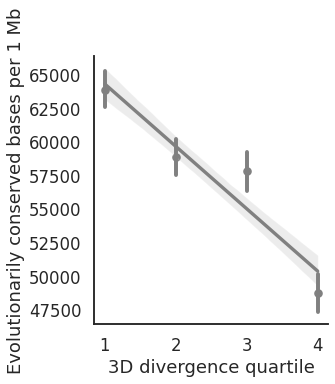

In [ ]:
g = sns.lmplot(x='divergence_percentile_group', y='numBases', data=annotation, x_estimator=np.mean, line_kws={'color': 'grey'}, scatter_kws={'color': 'grey'})
g.set(xticks=[1,2,3,4],xlabel="3D divergence quartile", ylabel="Evolutionarily conserved bases per 1 Mb")
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['divergence_percentile_group'],annotation['numBases'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))

In [ ]:
windows_by_pop['seq_id_all'] = seq_id.mean(axis=1)

In [ ]:
windows_by_pop['divergence_percentile'] = windows_by_pop['ALL_mean'].rank(pct=True)
windows_by_pop['divergence_percentile_group'] = windows_by_pop['divergence_percentile'].apply(PercentileToQuartile)

In [ ]:
windows_by_pop

AFR_mean  AMR_mean  EUR_mean  EAS_mean  SAS_mean  \
chr   windowStartPos                                                     
chr1  1048576         0.001596  0.000881  0.000648  0.001091  0.000889   
      1572864         0.002087  0.001167  0.001148  0.001519  0.001216   
      3145728         0.002669  0.003333  0.002607  0.004419  0.002747   
      3670016         0.004773  0.004380  0.004600  0.004405  0.004836   
      4194304         0.009120  0.008632  0.009555  0.007170  0.008487   
...                        ...       ...       ...       ...       ...   
chr22 46661632        0.004763  0.003424  0.003324  0.003265  0.002981   
      47185920        0.011735  0.005060  0.004423  0.006339  0.006914   
      47710208        0.055222  0.059584  0.060998  0.053654  0.047924   
      48234496        0.204803  0.219469  0.214279  0.197077  0.187636   
      48758784        0.008367  0.005016  0.004276  0.004971  0.005018   

                       AFR_std   AMR_std   EUR_std   EAS_std   SAS_std  \
chr   windowStartPos                                                     
chr1  1048576         0.000834  0.000565  0.000449  0.002823  0.000436   
      1572864         0.001091  0.000576  0.000514  0.003997  0.000899   
      3145728         0.002707  0.002587  0.002303  0.002527  0.002268   
      3670016         0.001677  0.001306  0.004735  0.001116  0.001610   
      4194304         0.002968  0.003223  0.009507  0.002685  0.003270   
...                        ...       ...       ...       ...       ...   
chr22 46661632        0.002922  0.001475  0.004090  0.001231  0.001646   
      47185920        0.011732  0.003434  0.002042  0.003512  0.020782   
      47710208        0.024968  0.026555  0.028428  0.028623  0.022950   
      48234496        0.058776  0.064189  0.073819  0.066296  0.056998   
      48758784        0.003559  0.002211  0.001532  0.001635  0.001988   

                      ALL_mean   ALL_std  AFR_top  AMR_top  EUR_top  EAS_top  \
chr   windowStartPos                                                           
chr1  1048576         0.001070  0.001436    False    False    False    False   
      1572864         0.001491  0.001996    False    False    False    False   
      3145728         0.003123  0.002591    False    False    False    False   
      3670016         0.004618  0.002516    False    False    False    False   
      4194304         0.008626  0.005136    False    False     True    False   
...                        ...       ...      ...      ...      ...      ...   
chr22 46661632        0.003650  0.002700    False    False    False    False   
      47185920        0.007318  0.011298     True    False    False    False   
      47710208        0.055384  0.026721     True     True     True     True   
      48234496        0.204137  0.064962     True     True     True     True   
      48758784        0.005755  0.002899    False    False    False    False   

                      SAS_top  seq_id_all  divergence_percentile  \
chr   windowStartPos                                               
chr1  1048576           False    0.998058               0.313975   
      1572864           False    0.998243               0.434845   
      3145728           False    0.997794               0.682742   
      3670016           False    0.997648               0.780628   
      4194304           False    0.997924               0.888775   
...                       ...         ...                    ...   
chr22 46661632          False    0.997902               0.721937   
      47185920          False    0.997987               0.865586   
      47710208           True    0.997543               0.993023   
      48234496           True    0.996917               1.000000   
      48758784          False    0.997153               0.826596   

                      divergence_percentile_group  
chr   windowStartPos                               
chr1  1048576                                   2  
      1572864 

r2 =  0.10227018529143915 p = 2.7458903588821507e-116


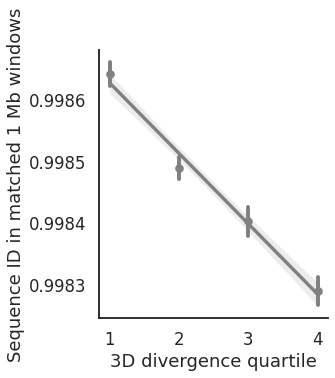

In [ ]:
g = sns.lmplot(x='divergence_percentile_group', y='seq_id_all', data=windows_by_pop, x_estimator=np.mean, line_kws={'color': 'grey'}, scatter_kws={'color': 'grey'})
g.set(xticks=[1,2,3,4],xlabel="3D divergence quartile", ylabel="Sequence ID in matched 1 Mb windows")
slope, intercept, r_value, p_value, std_err = stats.linregress(windows_by_pop['divergence_percentile_group'],windows_by_pop['seq_id_all'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))

r2 =  0.10227018529143915 p = 2.7458903588821507e-116


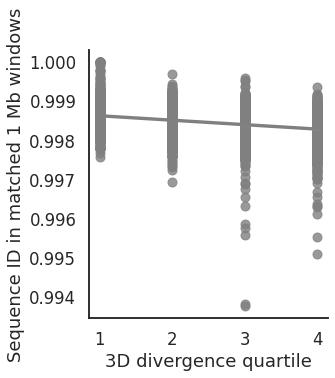

In [ ]:
g = sns.lmplot(x='divergence_percentile_group', y='seq_id_all', data=windows_by_pop, line_kws={'color': 'grey'}, scatter_kws={'color': 'grey'})
g.set(xticks=[1,2,3,4],xlabel="3D divergence quartile", ylabel="Sequence ID in matched 1 Mb windows")
slope, intercept, r_value, p_value, std_err = stats.linregress(windows_by_pop['divergence_percentile_group'],windows_by_pop['seq_id_all'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))

# Characterize subset individuals

In [37]:
inds = pd.read_table('%s/intermediates/subset_inds.csv'%DATA_PATH, sep=',', index_col=0)

In [38]:
inds

,0
0,AFR_GWD_female_HG02635
1,SAS_PJL_female_HG02725
2,EAS_CDX_female_HG01799
3,EAS_KHV_female_HG01874
4,EAS_CDX_female_HG01801
...,...
125,EAS_CHS_female_HG00531
126,SAS_PJL_female_HG02649
127,EUR_FIN_female_HG00373
128,AFR_GWD_female_HG02679


In [45]:
anc.loc[inds["0"]][anc.super_pop=='EAS']

/wynton/home/capra/egilbertson/envs/akita/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,ancestor,genome_avg_mse,genome_avg_spearman,super_pop,sub_pop,sex,id,divergence,super_rank,sub_rank
1KG,,,,,,,,,,
EAS_CDX_female_HG01799,hsmrca_ancestral,0.000664,0.995682,EAS,CDX,female,HG01799,0.004318,2,13
EAS_KHV_female_HG01874,hsmrca_ancestral,0.000653,0.995739,EAS,KHV,female,HG01874,0.004261,2,14
EAS_CDX_female_HG01801,hsmrca_ancestral,0.000634,0.995784,EAS,CDX,female,HG01801,0.004216,2,13
EAS_JPT_female_NA18998,hsmrca_ancestral,0.000691,0.995528,EAS,JPT,female,NA18998,0.004472,2,10
EAS_CHS_female_HG00608,hsmrca_ancestral,0.000653,0.995581,EAS,CHS,female,HG00608,0.004419,2,12
EAS_CDX_female_HG00864,hsmrca_ancestral,0.000624,0.995760,EAS,CDX,female,HG00864,0.004240,2,13
EAS_CDX_female_HG01807,hsmrca_ancestral,0.000660,0.995622,EAS,CDX,female,HG01807,0.004378,2,13
EAS_CDX_female_HG02188,hsmrca_ancestral,0.000655,0.995611,EAS,CDX,female,HG02188,0.004389,2,13
EAS_CHB_female_NA18591,hsmrca_ancestral,0.000660,0.995761,EAS,CHB,female,NA18591,0.004239,2,9


/wynton/home/capra/egilbertson/envs/akita/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(array([2., 4., 4., 4., 3., 3., 3., 0., 1., 1.]),
 array([0.00410907, 0.00416394, 0.0042188 , 0.00427367, 0.00432854,
        0.00438341, 0.00443828, 0.00449314, 0.00454801, 0.00460288,
        0.00465775]),
 <BarContainer object of 10 artists>)

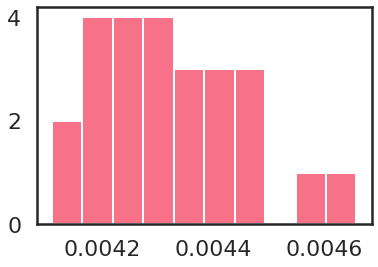

In [46]:
plt.hist(anc.loc[inds["0"]][anc.super_pop=='EAS'].divergence)

/wynton/home/capra/egilbertson/envs/akita/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


(array([1., 0., 0., 0., 0., 2., 5., 9., 5., 3.]),
 array([0.00147583, 0.00148052, 0.00148522, 0.00148991, 0.00149461,
        0.0014993 , 0.00150399, 0.00150869, 0.00151338, 0.00151808,
        0.00152277]),
 <BarContainer object of 10 artists>)

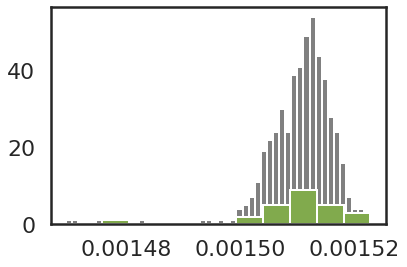

In [59]:

plt.hist(genome_wide_both[genome_wide_both.super_pop=='EAS'].seq_diff, color='grey', bins=50)
plt.hist(genome_wide_both.loc[inds["0"]][genome_wide_both.super_pop=='EAS'].seq_diff, color = (0.5061679352128585, 0.6675954483699535, 0.3024282922555064))

/wynton/home/capra/egilbertson/envs/akita/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


(array([2., 4., 4., 4., 3., 3., 3., 0., 1., 1.]),
 array([0.00410907, 0.00416394, 0.0042188 , 0.00427367, 0.00432854,
        0.00438341, 0.00443828, 0.00449314, 0.00454801, 0.00460288,
        0.00465775]),
 <BarContainer object of 10 artists>)

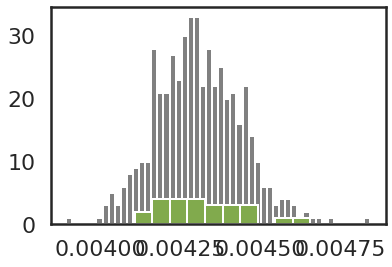

In [60]:

plt.hist(genome_wide_both[genome_wide_both.super_pop=='EAS'].divergence, color='grey', bins=50)
plt.hist(genome_wide_both.loc[inds["0"]][genome_wide_both.super_pop=='EAS'].divergence, color = (0.5061679352128585, 0.6675954483699535, 0.3024282922555064))